In [1]:
import pandas as pd
import torch.nn as nn
from sklearn.model_selection import train_test_split
from PIL import Image
import torch
from torchvision import transforms
import os
from more_itertools import peekable
import torch.optim.lr_scheduler as lr_scheduler
import matplotlib.pyplot as plt
from torch.cuda import is_available as is_cuda_available
import torch.nn.init as init
import random
from itertools import combinations, product
from torch.utils.data import Dataset, DataLoader
cwd = os.getcwd()
print(is_cuda_available())
print("Current working directory:", cwd)

True
Current working directory: /sise/home/amitfoye/code_files/DL_A2


# The Data

In [2]:
dataset_path = os.path.join(cwd, "lfw")
images_path = os.path.join(dataset_path, "lfw-deepfunneled", "lfw-deepfunneled")


## Loading The Given Pairs

### Load The Data

In [3]:

match_dev_test_df = pd.read_csv(os.path.join(dataset_path, "matchpairsDevTest.csv")).sort_index()
match_dev_train_df = pd.read_csv(os.path.join(dataset_path, "matchpairsDevTrain.csv")).sort_index()
mismatch_dev_test_df = pd.read_csv(os.path.join(dataset_path, "mismatchpairsDevTest.csv")).sort_index()
mismatch_dev_train_df = pd.read_csv(os.path.join(dataset_path, "mismatchpairsDevTrain.csv")).sort_index()

match_dev_train_df, match_dev_val_df = train_test_split(
    match_dev_train_df, test_size=0.2, random_state=42
)
mismatch_dev_train_df, mismatch_dev_val_df = train_test_split(
    mismatch_dev_train_df, test_size=0.2, random_state=42
)

match_dev_train_df = match_dev_train_df.reset_index(drop=True)
match_dev_val_df = match_dev_val_df.reset_index(drop=True)
mismatch_dev_train_df = mismatch_dev_train_df.reset_index(drop=True)
mismatch_dev_val_df = mismatch_dev_val_df.reset_index(drop=True)


### Preprocessing

In [4]:
match_dev_train_df['name1'] = match_dev_train_df['name']
match_dev_train_df['name2'] = match_dev_train_df['name']
match_dev_train_df = match_dev_train_df[['name1', 'imagenum1', 'name2', 'imagenum2']]
match_dev_train_df['label'] = 1

match_dev_val_df['name1'] = match_dev_val_df['name']
match_dev_val_df['name2'] = match_dev_val_df['name']
match_dev_val_df = match_dev_val_df[['name1', 'imagenum1', 'name2', 'imagenum2']]
match_dev_val_df['label'] = 1

match_dev_test_df['name1'] = match_dev_test_df['name']
match_dev_test_df['name2'] = match_dev_test_df['name']
match_dev_test_df = match_dev_test_df[['name1', 'imagenum1', 'name2', 'imagenum2']]
match_dev_test_df['label'] = 1

mismatch_dev_test_df['label'] = 0
mismatch_dev_train_df['label'] = 0
mismatch_dev_val_df['label'] = 0

train_df = pd.concat([match_dev_train_df, mismatch_dev_train_df], ignore_index=True).sample(frac=1).reset_index(drop=True)
val_df = pd.concat([match_dev_val_df, mismatch_dev_val_df], ignore_index=True).sample(frac=1).reset_index(drop=True)
test_df = pd.concat([match_dev_test_df, mismatch_dev_test_df], ignore_index=True).sample(frac=1).reset_index(drop=True)

## Generating Many Pairs

In [17]:
def generate_matched_pairs(people_df: pd.DataFrame, max_pairs: int = None) -> pd.DataFrame:
    matched_pairs = []
    total_pairs = 0
    for _, row in people_df.iterrows():
        name = row['name']
        num_images = int(row['images'])
        if num_images < 2:
            continue
        for i, j in combinations(range(1, num_images + 1), 2):
            matched_pairs.append([name, i, name, j, 1])
            total_pairs += 1
            if max_pairs and total_pairs >= max_pairs:
                return pd.DataFrame(matched_pairs, columns=['name1', 'imagenum1', 'name2', 'imagenum2', 'label'])
    matched_df = pd.DataFrame(matched_pairs, columns=['name1', 'imagenum1', 'name2', 'imagenum2', 'label'])
    return matched_df



def generate_mismatched_pairs(people_df: pd.DataFrame, pairs_per_person: int = 5, max_pairs: int = None) -> pd.DataFrame:
    mismatched_pairs = []
    mismatched_pairs_set = {}
    names = people_df['name'].tolist()
    name_to_count = dict(zip(people_df['name'], people_df['images']))
    total_pairs = 0

    for name1 in names:
        possible_others = [n for n in names if n != name1]
        sampled_others = random.sample(possible_others, min(len(possible_others), pairs_per_person))

        for name2 in sampled_others:
            if((name1, name2) in mismatched_pairs_set or (name2, name1) in mismatched_pairs_set):
                continue
            mismatched_pairs_set[(name1, name2)] = True
            num1 = name_to_count[name1]
            num2 = name_to_count[name2]
            for img1, img2 in product(range(1, num1 + 1), range(1, num2 + 1)):
                mismatched_pairs.append([name1, img1, name2, img2, 0])
                total_pairs += 1
                if max_pairs and total_pairs >= max_pairs:
                    return pd.DataFrame(mismatched_pairs, columns=['name1', 'imagenum1', 'name2', 'imagenum2', 'label'])
    
    mismatched_df = pd.DataFrame(mismatched_pairs, columns=['name1', 'imagenum1', 'name2', 'imagenum2', 'label'])
    return mismatched_df


In [18]:
people_train_df = pd.read_csv(os.path.join(dataset_path, "peopleDevTrain.csv")).sort_index()
people_test_df = pd.read_csv(os.path.join(dataset_path, "peopleDevTest.csv")).sort_index()

mismatch_dev_train_df = generate_mismatched_pairs(people_train_df, pairs_per_person=10, max_pairs=80000)
match_dev_train_df = generate_matched_pairs(people_train_df, max_pairs=80000)
mismatch_dev_test_df = generate_mismatched_pairs(people_test_df, pairs_per_person=10, max_pairs=20000)
match_dev_test_df = generate_matched_pairs(people_test_df, max_pairs=20000)

match_dev_train_df, match_dev_val_df = train_test_split(
    match_dev_train_df, test_size=0.2, random_state=42
)
mismatch_dev_train_df, mismatch_dev_val_df = train_test_split(
    mismatch_dev_train_df, test_size=0.2, random_state=42
)

match_dev_train_df = match_dev_train_df.reset_index(drop=True)
match_dev_val_df = match_dev_val_df.reset_index(drop=True)
mismatch_dev_train_df = mismatch_dev_train_df.reset_index(drop=True)
mismatch_dev_val_df = mismatch_dev_val_df.reset_index(drop=True)

train_df = pd.concat([match_dev_train_df, mismatch_dev_train_df], ignore_index=True).sample(frac=1).reset_index(drop=True)
val_df = pd.concat([match_dev_val_df, mismatch_dev_val_df], ignore_index=True).sample(frac=1).reset_index(drop=True)
test_df = pd.concat([match_dev_test_df, mismatch_dev_test_df], ignore_index=True).sample(frac=1).reset_index(drop=True)


## Loaders

In [5]:
# Create a dictionary to store the images
IMAGE_SIZE = 105

In [6]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to black and white
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),               # Resize to match model input
    transforms.ToTensor()                        # Converts to tensor and scales to [0, 1]
])


class SiameseDataset(Dataset):
    def __init__(self, df, root_dir, transform=None):
        self.df = df
        self.root_dir = root_dir
        self.transform = transform or transforms.ToTensor()

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        name1, imgnum1 = row['name1'], int(row['imagenum1'])
        name2, imgnum2 = row['name2'], int(row['imagenum2'])

        path1 = os.path.join(self.root_dir, name1, f"{name1}_{imgnum1:04d}.jpg")
        path2 = os.path.join(self.root_dir, name2, f"{name2}_{imgnum2:04d}.jpg")

        img1 = Image.open(path1).convert("RGB")
        img2 = Image.open(path2).convert("RGB")

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        label = torch.tensor([row['label']], dtype=torch.float32)
        return img1, img2, label


# Initializing The Network

In [ ]:
class SingularCNN(nn.Module):
    def __init__(self):
        super(SingularCNN, self).__init__()
        
        self.cnn = nn.Sequential(
            nn.BatchNorm2d(1),
            nn.Conv2d(1, 64, kernel_size=10), 
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(64, 128, kernel_size=7),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(128, 128, kernel_size=4),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, kernel_size=4),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(256 * 6 * 6, 4096),  # Fully connected layer
            nn.Sigmoid(),  # Activation function
        )

    def forward(self, X):
        return self.cnn(X)
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.normal_(m.weight, mean=0.0, std=1e-2)
                if m.bias is not None:
                    init.normal_(m.bias, mean=0.5, std=1e-2)
            elif isinstance(m, nn.Linear):
                init.normal_(m.weight, mean=0.0, std=2e-1)
                if m.bias is not None:
                    init.normal_(m.bias, mean=0.5, std=1e-2)
    
    


class TwinCNN(nn.Module):
    def __init__(self):
        super(TwinCNN, self).__init__()
        
        # Share the same SiameseCNN instance for both branches
        self.scnn1 = SingularCNN()
        self.scnn2 = self.scnn1  # Use the same SiameseCNN instance for shared weights

        self.fc = nn.Sequential(
            nn.Linear(4096, 1),
            nn.Sigmoid()  # As used in the original paper
        )
        
    def forward(self, X1, X2):
        out1 = self.scnn1(X1)
        out2 = self.scnn2(X2)  # Same weights are used here due to reference
        out = torch.abs(out1 - out2)
        return self.fc(out)
    
    def predict(self, X1, X2):
        out1 = self.scnn1(X1)
        out2 = self.scnn2(X2)  # Same weights are used here due to reference
        out = torch.abs(out1 - out2)
        out = out.view(out.size(0), -1)
        return torch.sigmoid(out)


## Training The Twins

In [8]:
import time

def train(model, train_df, val_df, test_df, loss_fn, optimizer, device, epochs=10, batch_size=32):
    model.to(device)
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    test_accuracies = []
    test_losses = []

    train_dataset = SiameseDataset(train_df, transform=transform, root_dir=images_path)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_dataset = SiameseDataset(val_df, transform=transform, root_dir=images_path)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    test_dataset = SiameseDataset(test_df, transform=transform, root_dir=images_path)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    start_time = time.time()  # Start timer

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        num_batches = 0  

        for inputs1, inputs2, targets in train_loader:
            inputs1, inputs2, targets = inputs1.to(device), inputs2.to(device), targets.to(device)
            num_batches += 1
            optimizer.zero_grad()
            outputs = model(inputs1, inputs2)
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            with torch.no_grad():
                predicted = (outputs > 0.5)
                train_total += targets.shape[0]
                train_correct += predicted.eq(targets).sum().item()

        avg_train_loss = train_loss / num_batches
        train_losses.append(avg_train_loss)
        train_accuracies.append(100. * train_correct / train_total)

        # Validation
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        num_batches = 0

        with torch.no_grad():
            for inputs1, inputs2, targets in val_loader:
                inputs1, inputs2, targets = inputs1.to(device), inputs2.to(device), targets.to(device)
                num_batches += 1
                outputs = model(inputs1, inputs2)
                loss = loss_fn(outputs, targets)
                val_loss += loss.item()
                predicted = (outputs > 0.5)
                val_total += targets.shape[0]
                val_correct += predicted.eq(targets).sum().item()

        avg_val_loss = val_loss / num_batches
        val_accuracy = 100. * val_correct / val_total
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        # Test
        model.eval()
        test_loss = 0
        test_correct = 0
        test_total = 0
        num_batches = 0
        with torch.no_grad():
            for inputs1, inputs2, targets in test_loader:
                inputs1, inputs2, targets = inputs1.to(device), inputs2.to(device), targets.to(device)
                num_batches += 1
                outputs = model(inputs1, inputs2)
                loss = loss_fn(outputs, targets)
                test_loss += loss.item()

                predicted = (outputs > 0.5)
                test_total += targets.shape[0]
                test_correct += predicted.eq(targets).sum().item()
        test_accuracies.append(100. * test_correct / test_total)
        test_losses.append(test_loss / num_batches)

        elapsed_time = (time.time() - start_time) / 60  # Minutes since training started

        print(f"[{elapsed_time:.2f} min] Epoch {epoch+1}/{epochs} "
              f"Train Loss: {avg_train_loss:.4f} "
              f"Val Loss: {avg_val_loss:.4f} "
              f"Val Accuracy: {val_accuracy:.2f}%")

    return train_losses, train_accuracies, val_losses, val_accuracies, test_losses, test_accuracies


## Actual Training

In [23]:
import gc

# Delete your tensors or model if you're done with them
#del model
#del optimizer
# del any_other_tensor

gc.collect()                # Collect garbage
torch.cuda.empty_cache()    # Free up unused cached memory


In [9]:
model = TwinCNN()
device = torch.device("cuda" if is_cuda_available() else "cpu")

In [10]:
batch_size = 128
initial_lr = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=initial_lr, weight_decay=1e-4)

loss_fn = nn.BCELoss()
train_losses, train_accuracies, val_losses, val_accuracies, test_losses, test_accuracies = train(
    model,
    train_df,
    val_df,
    test_df,
    loss_fn,
    optimizer,
    device,
    epochs=100,
    batch_size=batch_size
)

[0.08 min] Epoch 1/100 Train Loss: 46.5303 Val Loss: 48.9955 Val Accuracy: 50.00%
[0.13 min] Epoch 2/100 Train Loss: 50.0930 Val Loss: 48.9955 Val Accuracy: 50.00%
[0.19 min] Epoch 3/100 Train Loss: 50.0930 Val Loss: 48.2607 Val Accuracy: 50.00%
[0.24 min] Epoch 4/100 Train Loss: 49.5434 Val Loss: 51.0045 Val Accuracy: 50.00%
[0.30 min] Epoch 5/100 Train Loss: 50.0186 Val Loss: 51.0045 Val Accuracy: 50.00%


KeyboardInterrupt: 

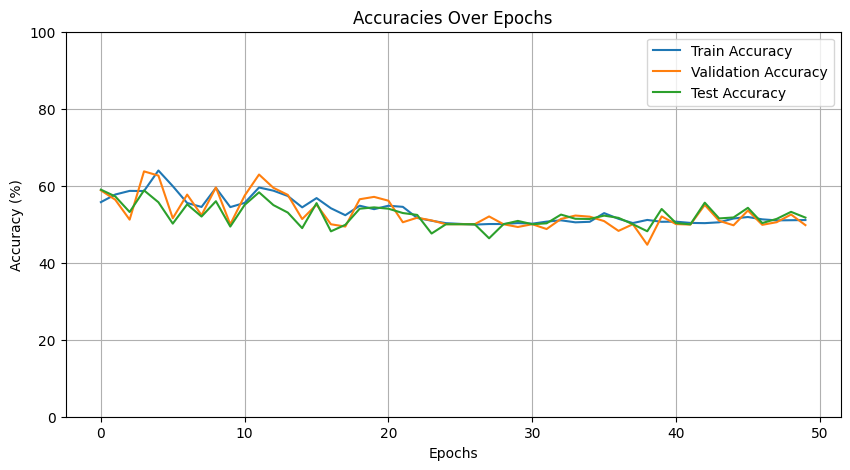

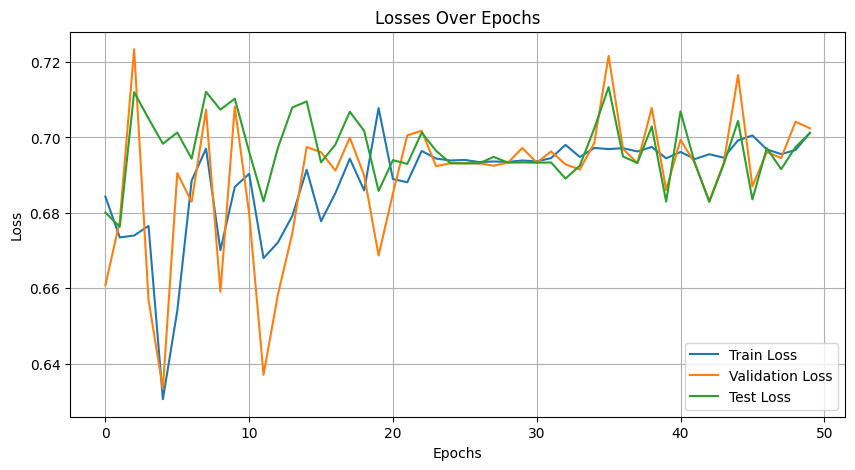

In [26]:
# Plot accuracies
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.plot(test_accuracies, label="Test Accuracy")
plt.ylim(0, 100)  # Limit y-axis from 0 to 100
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Accuracies Over Epochs")
plt.legend()
plt.grid()
plt.savefig("accuracy_plot.png")
plt.show()

# Plot losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Losses Over Epochs")
plt.legend()
plt.grid()
plt.savefig("loss_plot.png")
plt.show()